<a href="https://colab.research.google.com/github/MajiroZ/for_git_study/blob/master/CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image shape: torch.Size([64, 1, 28, 28])


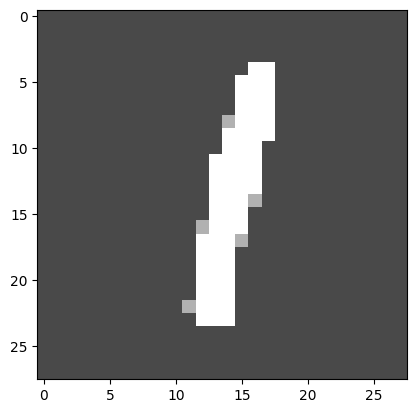

tensor(1)

In [3]:
import torch
from torchvision import datasets, transforms, utils

# MNISTデータセットのダウンロードと変換
transform = transforms.Compose([
    transforms.ToTensor(),  # 画像データをTensorに変換
    transforms.Normalize((0.1307,), (0.3081,))  # 平均と標準偏差で正規化
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoaderの作成
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)

# データの形状確認 (NCHW形式)
for images, labels in train_loader:
    print("Image shape:", images.shape) # 例: torch.Size([64, 1, 28, 28])
    break

# データセットのサンプル表示
import matplotlib.pyplot as plt

# 画像を可視化する関数
def show_image(img):
    img = img / 2 + 0.5     # 正規化を元に戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# データセットからサンプル画像を取得
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 最初の画像を表示
import numpy as np
show_image(utils.make_grid(images[0]))
labels[0]

In [4]:
# 学習データとテストデータの作成
X_train = []
y_train = []
X_pred = []
y_pred = []

for images, labels in train_loader:
    X_train.append(images)
    y_train.append(labels)

for images, labels in test_loader:
    X_pred.append(images)
    y_pred.append(labels)

# リストをTensorに変換
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_pred = torch.cat(X_pred, dim=0)
y_pred = torch.cat(y_pred, dim=0)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_pred shape:", X_pred.shape)
print("y_pred shape:", y_pred.shape)

X_train shape: torch.Size([60000, 1, 28, 28])
y_train shape: torch.Size([60000])
X_pred shape: torch.Size([10000, 1, 28, 28])
y_pred shape: torch.Size([10000])


##【問題1】2次元畳み込み層の作成

In [5]:
class SimpleConv2d():
    def __init__(self, F, C, FH, FW, P, S, initializer=None, optimizer=None, activation=None):
        self.P = P
        self.S = S
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        self.W = self.initializer.W(F, C, FH, FW)
        self.B = self.initializer.B(F)

    def output_shape2d(self, H, W, PH, PW, FH, FW, SH, SW):
        OH = (H + 2 * PH - FH) / SH + 1
        OW = (W + 2 * PW - FW) / SW + 1
        return int(OH), int(OW)

    def forward(self, X,debug=False):
        self.X = X
        N,C,H,W = self.X.shape
        F,C,FH,FW = self.W.shape
        OH,OW = self.output_shape2d(H,W,self.P,self.P,FH,FW,self.S,self.S)
        self.params = N,C,H,W,F,FH,FW,OH,OW
        A = np.zeros([N,F,OH,OW])
        self.X_pad = np.pad(self.X,((0,0),(0,0),(self.P,self.P),(self.P,self.P)))
        for n in range(N):
            for ch in range(F):
                for row in range(0,H,self.S):
                    for col in range(0,W,self.S):
                        if self.P == 0 and (W-2 <= col or H-2<=row):
                            continue
                        A[n,ch,row,col] = np.sum(self.X_pad[n,:,row:row+FH,col:col+FW]*self.W[ch,:,:,:]) +self.B[ch]
        if debug == True:
            return A
        else:
            return self.activation.forward(A)

    def backward(self, dZ,debug=False):
        if debug==True:
            dA = dZ
        else:
            dA = self.activation.backward(dZ)
        N,C,H,W,F,FH,FW,OH,OW = self.params
        dZ = np.zeros(self.X_pad.shape)
        self.dW = np.zeros(self.W.shape)
        self.dB = np.zeros(self.B.shape)
        for n in range(N):
            for ch in range(F):
                for row in range(0,H,self.S):
                    for col in range(0,W,self.S):
                        if self.P == 0 and (W-2 <= col or H-2<=row):
                            continue
                        dZ[n,:,row:row+FH,col:col+FW] += dA[n,ch,row,col]*self.W[ch,:,:,:]
        if self.P == 0:
            dZ = np.delete(dZ,[0,H-1],axis=2)
            dZ = np.delete(dZ,[0,W-1],axis=3)
        else:
            dl_rows = range(self.P),range(H+self.P,H+2*self.P)
            dZ = np.delete(dZ,dl_rows,axis=2)
            dl_cols = range(self.P),range(W+self.P,W+2*self.P)
            dZ = np.delete(dZ,dl_cols,axis=3)

In [6]:
class ReLU:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)
class ReLU:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)

class SGD:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return

In [7]:
class SimpleInitializerConv2d():
    def __init__(self,sigma=0.01):
        self.sigma = sigma
    def W(self,F,C,FH,FW):
        return self.sigma * np.random.randn(F,C,FH,FW)
    def B(self,F):
        return np.zeros(F)

    def output_shaped2d(self, H, W, PH, PW, FH, FW, SH, SW):
        OH = (H + 2 * PH - FH) / SH + 1
        OW = (W + 2 * PW - FW) / SW + 1
        return int(OH), int(OW)

    def forward(self, X,debug=False):
        self.X = X
        N,C,H,W = self.X.shape
        F,C,FH,FW = self.W.shape
        OH,OW = self.output_shape2d(H,W,self.P,self.P,FH,FW,self.S,self.S)
        self.params = N,C,H,W,F,FH,FW,OH,OW
        A = np.zeros([N,F,OH,OW])
        self.X_pad = np.pad(self.X,((0,0),(0,0),(self.P,self.P),(self.P,self.P)))
        for n in range(N):
            for ch in range(F):
                for row in range(0,H,self.S):
                    for col in range(0,W,self.S):
                        if self.P == 0 and (W-2 <= col or H-2<=row):
                            continue
                        A[n,ch,row,col] = np.sum(self.X_pad[n,:,row:row+FH,col:col+FW]*self.W[ch,:,:,:]) +self.B[ch]
        if debug==True:
            return A
        else:
            return  self.activation.forward(A)

    def backward(self, dZ,debug=False):
        if debug==True:
            dA = dZ
        else:
            dA = self.activation.backward(dZ)
        N,C,H,W,F,FH,FW,OH,OW = self.params
        dZ = np.zeros(self.X_pad.shape)
        self.dW = np.zeros(self.W.shape)
        self.dB = np.zeros(self.B.shape)
        for n in range(N):
            for ch in range(F):
                for row in range(0,H,self.S):
                    for col in range(0,W,self.S):
                        if self.P == 0 and (W-2 <= col or H-2<=row):
                            continue
                        dZ[n,:,row:row+FH,col:col+FW] += dA[n,ch,row,col]*self.W[ch,:,:,:]
        if self.P == 0:
            dZ = np.delete(dZ,[0,H-1],axis=2)
            dZ = np.delete(dZ,[0,W-1],axis=3)
        else:
            dl_rows = range(self.P),range(H+self.P,H+2*self.P,1)
            dl_cols = range(self.P),range(W+self.P,W+2*self.P,1)
            dZ = np.delete(dZ,dl_rows,axis=2)
            dZ = np.delete(dZ,dl_cols,axis=3)
        for n in range(N):
            for ch in range(F):
                for row in range(OH):
                    for col in range(OW):
                        self.dW[ch,:,:,:] += dA[n,ch,row,col]*self.X_pad[n,:,row:row+FH,col:col+FW]
        for ch in range(F):
            self.dB[ch] = np.sum(dA[:,ch,:,:])
        self = self.optimizer.update(self)
        return dZ

##【問題2】小さな配列での2次元畳み込み層の実験

In [8]:
# CNN2 のフォワードを流す時の入力データ
# (1,1,4,4)
x = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])

# (2,3,3)
w = np.array([[[ 0.,  0.,  0.],
               [ 0.,  1.,  0.],
               [ 0., -1.,  0.]],

              [[ 0.,  0.,  0.],
               [ 0., -1.,  1.],
               [ 0.,  0.,  0.]]])

In [9]:
w = w.reshape(2, 1, 3, 3)
simple_conv_2d = SimpleConv2d(F=2, C=1, FH=3, FW=3, P=0, S=1, initializer=SimpleInitializerConv2d(), optimizer=SGD(lr=0.01), activation=ReLU())
simple_conv_2d.W = w
A = simple_conv_2d.forward(x, True)
print(A)

[[[[-4. -4.]
   [-4. -4.]]

  [[ 1.  1.]
   [ 1.  1.]]]]


In [10]:
da = np.array([[[[ -4,  -4], [ 10,  11]],[[  1,  -7],[  1, -11]]]])
dZ = simple_conv_2d.backward(da,True)
print(dZ)

None


##【問題3】2次元畳み込み後の出力サイズ

In [11]:
simple_conv_2d.output_shape2d(H=6,W=6,PH=0,PW=0,FH=3,FW=3,SH=1,SW=1)

(4, 4)

##【問題4】最大プーリング層の作成

In [12]:
class MaxPool2D():
    def __init__(self,P):
        self.P = P
        self.PA = None
        self.Pindex = None

    def forward(self,A):
        N, F, OH, OW = A.shape
        PH,PW = int(OH/self.P),int(OW/self.P)
        self.params = N,F,OH,OW,self.P,PH,PW
        self.PA = np.zeros([N,F,PH,PW])
        self.Pindex = np.zeros([N,F,PH,PW])
        for n in range(N):
            for ch in range(F):
                for row in range(PH):
                    for col in range(PW):
                        self.PA[n,ch,row,col] = np.max(A[n,ch,row*self.P:row*self.P+self.P,col*self.P:col*self.P+self.P])
                        self.Pindex[n,ch,row,col] = np.argmax(A[n,ch,row*self.P:row*self.P+self.P,col*self.P:col*self.P+self.P])
        return self.PA

    def backward(self,dA):
        N,F,OH,OW,PS,PH,PW = self.params
        dP = np.zeros([N,F,OH,OW])
        for n in range(N):
            for ch in range(F):
                for row in range(PH):
                    for col in range(PW):
                        idx = self.Pindex[n,ch,row,col]
                        tmp = np.zeros((PS*PS))
                        for i in range(PS*PS):
                            if i == idx:
                                tmp[i] = dA[n,ch,row,col]
                            else:
                                tmp[i] = 0
                        dP[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS] = tmp.reshape(PS,PS)
        return dP

##【問題5】平均プーリングの作成

In [13]:
class AveragePool2D():
    def __init__(self, P):
        self.P = P
        self.PA = None
        self.params = None

    def forward(self, A):
        N, F, OH, OW = A.shape
        PH, PW = int(OH / self.P), int(OW / self.P)
        self.params = N, F, OH, OW, self.P, PH, PW
        self.PA = np.zeros([N, F, PH, PW])
        for n in range(N):
            for ch in range(F):
                for row in range(PH):
                    for col in range(PW):
                        self.PA[n, ch, row, col] = np.mean(A[n, ch, row * self.P:row * self.P + self.P, col * self.P:col * self.P + self.P])
        return self.PA

    def backward(self, dA):
        N, F, OH, OW, PS, PH, PW = self.params
        dP = np.zeros([N, F, OH, OW])
        for n in range(N):
            for ch in range(F):
                for row in range(PH):
                    for col in range(PW):
                        dP[n, ch, row * PS:row * PS + PS, col * PS:col * PS + PS] = dA[n, ch, row, col] / (PS * PS)
        return dP

##【問題6】平滑化

In [14]:
class Flatten:
    def __init__(self):
        pass
    def forward(self,X):
        self.shape = X.shape
        return X.reshape(len(X),-1)
    def backward(self,X):
        return X.reshape(self.shape)

##【問題7】学習と推定

In [15]:
class Scratch2dCNNClassifier():
    def __init__(self, NN, CNN, n_epoch=5, n_batch=1, verbose = False):
        self.NN = NN
        self.CNN = CNN
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.verbose = verbose
        self.log_loss = np.zeros(self.n_epoch)
        self.log_acc = np.zeros(self.n_epoch)


    def loss_function(self,y,yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))
    def accuracy(self,Z,Y):
        return accuracy_score(Y,Z)

    def predict(self, X):
        pred_data = X
        for layer in range(len(self.CNN)):
            pred_data = self.CNN[layer].forward(pred_data)
        pred_data = flt.forward(pred_data)
        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)
        return np.argmax(pred_data,axis=1)

    def fit(self, X, y, X_val=False, y_val=False):
        for epoch in range(self.n_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)
            self.n_batches = get_mini_batch.n_batches
            self.loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                forward_data = mini_X_train
                for layer in range(len(self.CNN)):
                    forward_data = self.CNN[layer].forward(forward_data)
                flt = Flatten()
                forward_data = flt.forward(forward_data)
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)
                Z = forward_data
                mini_y_train = mini_y_train.numpy()

                backward_data = (Z - mini_y_train)/self.n_batch
                for layer in range(len(self.NN)-1,-1,-1):
                    backward_data = self.NN[layer].backward(backward_data)
                backward_data = flt.backward(backward_data)
                for layer in range(len(self.CNN)-1,-1,-1):
                    backward_data = self.CNN[layer].backward(backward_data)
                self.loss += self.loss_function(Z,mini_y_train)
                if self.verbose:
                    print('batch loss %f'%self.loss_function(Z,mini_y_train))
            if self.verbose:
                print(self.loss/len(get_mini_batch),self.accuracy(self.predict(X),np.argmax(y,axis=1)))
            self.log_loss[epoch] = self.loss / self.n_batches
            self.log_acc[epoch] = self.accuracy(self.predict(X),np.argmax(y,axis=1))

In [16]:
!pip install numpy
import numpy as np

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
        self.optimizer = optimizer
        self.activation = activation
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        A = X @ self.W + self.B
        return self.activation.forward(A)

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = self.activation.backward(dA)
        self.dB = np.sum(dZ, axis=0)
        self.dW = self.X.T @ dZ
        dZ = dZ @ self.W.T
        # 更新
        self = self.optimizer.update(self)
        return dZ
class HeInitializer:
    def __init__(self):
        pass

    def W(self, n_nodes1, n_nodes2):
        """
        Weight initialization with He initialization.
        """
        self.sigma = np.sqrt(2 / n_nodes1)  # He initialization
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        """
        Bias initialization with zeros.
        """
        return np.zeros(n_nodes2)

In [17]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1
    def update(self, layer):
        self.HW += layer.dW**2
        self.HB += layer.dB**2
        layer.W -= self.lr * np.sqrt(1/self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1/self.HB) * layer.dB
        return layer

In [18]:
class SimpleInitializer:
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return np.zeros(n_nodes2)

In [19]:
class Softmax:
    def __init__(self):
        pass
    def forward(self, A):
        self.Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1,1)
        return self.Z
    def backward(self, Y):
        return self.Z - Y

In [20]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        np.random.seed(seed)
        self.n_batches = int(np.ceil(X.shape[0] / batch_size)) #ceilは切り上げ

    def __iter__(self):
        self.idx = np.arange(self.X.shape[0]) #arangeで0からデータ数-1までの配列作成
        np.random.shuffle(self.idx) #indexをシャッフル
        for i in range(self.n_batches):
            start = i * self.batch_size
            end = start + self.batch_size
            #indexのstartからendまでのデータを取得
            #yieldで返すことでイテレータとして使用可能
            yield self.X[self.idx[start:end]], self.y[self.idx[start:end]]

In [21]:
NN = {
    0:FC(1960, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
    1:FC(200, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
    2:FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
}
CNN = {
    0:SimpleConv2d(F=10, C=1, FH=3, FW=3, P=1, S=1,initializer=SimpleInitializerConv2d(),optimizer=SGD(lr=0.01),activation=ReLU()),
    1:MaxPool2D(2),
}

In [22]:
import torch.nn.functional as F

y_train_one_hot = F.one_hot(y_train, num_classes=10).float()

In [23]:
cnn1 = Scratch2dCNNClassifier(NN=NN,CNN=CNN,n_epoch=1,n_batch=20,verbose=True)

補足：ここでそのまま回したところ、毎回7時間程度かかり、エラーを吐いたり精度が非常に低かったため断念し、Torchを使うことにした。

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# データ変換とローダーの作成
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# モデル定義
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # 出力チャンネル数=32, カーネルサイズ=3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # 出力チャンネル数=64, カーネルサイズ=3
        self.pool = nn.MaxPool2d(2)                  # プーリングサイズ=2
        self.fc1 = nn.Linear(64 * 12 * 12, 128)        # 入力: 64チャンネル×12×12
        self.fc2 = nn.Linear(128, 10)                # 出力: クラス数(10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# モデル・損失関数・オプティマイザ
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習ループ
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 順伝播と損失計算
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 勾配リセット、逆伝播、パラメータ更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# テスト
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Epoch [1/5], Loss: 0.1135
Epoch [2/5], Loss: 0.0339
Epoch [3/5], Loss: 0.0210
Epoch [4/5], Loss: 0.0144
Epoch [5/5], Loss: 0.0100
Accuracy: 98.89%


##【問題8】LeNet

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# LeNetモデルの定義
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)  # 畳み込み層1
        self.relu = nn.ReLU()                                 # ReLU活性化関数
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)     # 最大プーリング
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)  # 畳み込み層2
        self.fc1 = nn.Linear(16 * 4 * 4, 120)                 # 平滑化後の全結合層1
        self.fc2 = nn.Linear(120, 84)                        # 全結合層2
        self.fc3 = nn.Linear(84, 10)                         # 全結合層3 (出力)

    def forward(self, x):
        x = self.relu(self.conv1(x))  # 畳み込み -> ReLU
        x = self.pool(x)              # プーリング
        x = self.relu(self.conv2(x))  # 畳み込み -> ReLU
        x = self.pool(x)              # プーリング
        x = x.view(x.size(0), -1)     # 平滑化
        x = self.relu(self.fc1(x))    # 全結合 -> ReLU
        x = self.relu(self.fc2(x))    # 全結合 -> ReLU
        x = self.fc3(x)               # 出力層
        return x

# MNISTデータセットの準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 平均0.5、標準偏差0.5で正規化
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# モデル、損失関数、最適化関数の定義
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# モデルのトレーニング
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 順伝播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 逆伝播と最適化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# モデルの評価
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Epoch [1/10], Loss: 0.2643
Epoch [2/10], Loss: 0.0746
Epoch [3/10], Loss: 0.0537
Epoch [4/10], Loss: 0.0421
Epoch [5/10], Loss: 0.0344
Epoch [6/10], Loss: 0.0282
Epoch [7/10], Loss: 0.0256
Epoch [8/10], Loss: 0.0218
Epoch [9/10], Loss: 0.0187
Epoch [10/10], Loss: 0.0151
Test Accuracy: 98.85%


##【問題9】有名な画像認識モデルの調査

テキストに記載されているURLはnot foundになってしまい読み込めなかった。

##【問題10】出力サイズとパラメータ数の計算

In [25]:
def calculate_output_size(input_size, filter_size, stride, padding):
    """
    Calculate the output size of a convolutional layer.
    Args:
        input_size (tuple): Input dimensions (H, W).
        filter_size (int): Size of the square filter.
        stride (int): Stride of the convolution.
        padding (int): Amount of padding (usually 0 or 'same').

    Returns:
        tuple: Output dimensions (H_out, W_out).
    """
    H, W = input_size
    H_out = (H - filter_size + 2 * padding) // stride + 1
    W_out = (W - filter_size + 2 * padding) // stride + 1
    return H_out, W_out

def calculate_parameters(filter_size, input_channels, output_channels, include_bias=True):
    """
    Calculate the number of parameters in a convolutional layer.
    Args:
        filter_size (int): Size of the square filter.
        input_channels (int): Number of input channels.
        output_channels (int): Number of output channels.
        include_bias (bool): Whether to include bias parameters.

    Returns:
        int: Total number of parameters.
    """
    filter_params = filter_size * filter_size * input_channels * output_channels
    bias_params = output_channels if include_bias else 0
    return filter_params + bias_params

# 1st layer
input_size_1 = (144, 144)
filter_size_1 = 3
stride_1 = 1
padding_1 = 0
input_channels_1 = 3
output_channels_1 = 6

output_size_1 = calculate_output_size(input_size_1, filter_size_1, stride_1, padding_1)
parameters_1 = calculate_parameters(filter_size_1, input_channels_1, output_channels_1)

# 2nd layer
input_size_2 = (60, 60)
filter_size_2 = 3
stride_2 = 1
padding_2 = 0
input_channels_2 = 24
output_channels_2 = 48

output_size_2 = calculate_output_size(input_size_2, filter_size_2, stride_2, padding_2)
parameters_2 = calculate_parameters(filter_size_2, input_channels_2, output_channels_2)

# 3rd layer
input_size_3 = (20, 20)
filter_size_3 = 3
stride_3 = 2
padding_3 = 0
input_channels_3 = 10
output_channels_3 = 20

output_size_3 = calculate_output_size(input_size_3, filter_size_3, stride_3, padding_3)
parameters_3 = calculate_parameters(filter_size_3, input_channels_3, output_channels_3)

print("1st layer:")
print(f"Output size: {output_size_1}")
print(f"Number of parameters: {parameters_1}")

print("\n2nd layer:")
print(f"Output size: {output_size_2}")
print(f"Number of parameters: {parameters_2}")

print("\n3rd layer:")
print(f"Output size: {output_size_3}")
print(f"Number of parameters: {parameters_3}")

1st layer:
Output size: (142, 142)
Number of parameters: 168

2nd layer:
Output size: (58, 58)
Number of parameters: 10416

3rd layer:
Output size: (9, 9)
Number of parameters: 1820


##【問題11】フィルタサイズに関する調査

1. 3×3フィルタが一般的な理由

* パラメータ数の削減: 大きなフィルタ（7×7など）と比較して、3×3フィルタは同等の受容野を持ちながら、はるかに少ないパラメータで実現る。例えば、7×7フィルタは49個のパラメータが必要ですが、3×3フィルタを3回重ねて適用すると、同等の受容野を9個のパラメータで実現できる。

* 計算効率: 小さなフィルタを重ねて適用することで、同じ計算量でより深いネットワークを構築できる。これにより、より複雑な特徴の抽出が可能になる。

* 非線形性の導入: フィルタを重ねることで、各層間に活性化関数（ReLUなど）を挿入できるため、ネットワークの表現力が向上する。
---
2. 1×1フィルタの効果

1×1畳み込み（ポイントワイズ畳み込み）は一見すると直感的ではないが……

* チャネル数の調整: 1×1畳み込みは、入力テンソルのチャネル数を増減させることができる。これにより、ネットワークの幅（チャネル数）を効率的に制御できる。

* 特徴量の非線形な変換: 1×1畳み込みは、各空間位置で異なるチャネル間の線形結合と非線形活性化を可能にする。これは、特徴量の再校正や情報の圧縮に役立つ。

* 計算量の削減: Inception moduleやResNetなどの高度なアーキテクチャでは、1×1畳み込みを使用して計算量を削減しながら、ネットワークの表現力を維持している。
---
これらの理由により、現代のCNNアーキテクチャでは3×3と1×1のフィルタが主流となっている。フィルタサイズの選択は、モデルの性能、計算効率、パラメータ数のバランスを取る上で重要な設計要素である。

また、3×3フィルタに関しては、数学的な観点からも興味深い特性がある。3×3は最小の対称的な正方形フィルタであり、任意の大きな畳み込みフィルタを3×3フィルタの重ね合わせで近似できることが証明されている。つまり、7×7や5×5のフィルタを3×3のフィルタで置き換えても、ほぼ同等の特徴抽出が可能である。
1×1フィルタについては、特にGoogleのネットワークアーキテクチャ研究（Inception moduleなど）で大きな役割を果たした。チャネル間の情報の再構成や、計算量の大幅な削減を可能にする、いわば「次元変換」の役割を果たす。